In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime
pd.set_option('display.max_columns', 5000)

In [2]:
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv  -o ../data/raw/counties_09-11.csv
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/deaths_timeseries.csv -o ../data/raw/time_series_covid19_deaths_US_06-19.csv
# !curl https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D -o ../data/raw/hospitals.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv -o ../data/raw/DL-us-m50.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50_index.csv -o ../data/raw/DL-us-m50_index.csv
# !curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv -o ../data/raw/time_series_covid19_deaths_US_05-22.csv
# !curl https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=694ae9957380f150 -o ../data/raw/google_mobility_report_06-14-20.csv
# !curl https://raw.githubusercontent.com/HopkinsIDD/hit-covid/master/data/hit-covid-longdata.csv -o ../data/raw/hit_covid_interventions_06-26-20.csv
# !curl https://raw.githubusercontent.com/Keystone-Strategy/covid19-intervention-data/master/complete_npis_raw_policies.csv -o ../data/raw/complete_npis_inherited_policies_keystone_06_26.csv # have to delete first cell/ttitle
# !curl https://raw.githubusercontent.com/COVID19StatePolicy/SocialDistancing/master/data/USstatesCov19distancingpolicy.csv -o ../data/raw/USstatesCov19distancingpolicy_07_01.csv
# !curl https://data.cms.gov/resource/s2uc-8wxp.csv -o ../data/raw/longtermcare_deaths_07_08.csv

In [3]:
hospitals = pd.read_csv('../data/raw/hospitals.csv')
hospitals.columns

Index(['FID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'ZIP4',
       'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY', 'COUNTYFIPS',
       'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'STATE_ID',
       'ALT_NAME', 'ST_FIPS', 'OWNER', 'TTL_STAFF', 'BEDS', 'TRAUMA',
       'HELIPAD'],
      dtype='object')

## Pull Hospital Data

### Long-term Care Hospitals

In [4]:
longterm_all = pd.read_csv('../data/raw/Long-_Term_Care_Hospital_-_General_Information.csv')
longterm_all['Long-term beds'] = longterm_all['Total Number of Beds']
longterm_all = longterm_all.drop(columns='Total Number of Beds')
fipscodes = pd.read_csv('../data/raw/countyfipstool2019.csv').filter(['sab', 'cname', 'fips'])
longterm_all = fipscodes.merge(longterm_all, left_on=['sab', 'cname'], right_on=['State', 'County Name'])
longterm_all['FIPS'] = longterm_all['fips']
longterm_all = longterm_all.drop(columns=['sab', 'cname', 'fips', 'State', 'County Name'])
longterm = longterm_all.filter(['FIPS', 'Long-term beds', 'State', 'County Name'])
longterm = longterm.dropna()
longterm.head()

,FIPS,Long-term beds
0,1015,38
1,1069,35
2,1073,38
3,1073,45
4,1083,31


In [5]:
fips_groups =longterm.groupby("FIPS")

LT_hosp_data = pd.DataFrame(columns=['FIPS', 'Longterm HospCt', 'Longterm Beds'])
for fips_code, grp in fips_groups:
    LT_hosp_data = LT_hosp_data.append({'FIPS': fips_code, 'Longterm HospCt': len(grp), 'Longterm Beds': sum(grp['Long-term beds'])}, ignore_index=True)   

LT_hosp_data.head()

,FIPS,Longterm HospCt,Longterm Beds
0,1015,1,38
1,1069,1,35
2,1073,2,83
3,1083,1,31
4,1097,1,22


### Nursing Homes

In [6]:
nursing_homes = pd.read_csv('../data/raw/Nursing_Homes.csv').filter(['COUNTYFIPS','BEDS', 'STATUS'])
nursing_homes = nursing_homes[nursing_homes['STATUS'] == 'OPEN']
nursing_homes = nursing_homes.drop(columns='STATUS')
nursing_homes.head()

,COUNTYFIPS,BEDS
0,54019,58
1,51153,107
2,37051,170
3,25017,-999
4,55035,6


In [7]:
nursing = pd.DataFrame(columns=['FIPS', 'NursingCt', 'NursingBeds'])
nursing_fips = nursing_homes.groupby('COUNTYFIPS')
for fips, grp in nursing_fips:
    nursing = nursing.append({'FIPS': fips, 'NursingCt': len(grp), 'NursingBeds': sum(grp['BEDS'])}, ignore_index=True)
nursing.head()

,FIPS,NursingCt,NursingBeds
0,1001,6,315
1,1003,25,1816
2,1005,3,212
3,1007,1,131
4,1009,9,367


### General Hospitals

In [8]:
# Created by Michael
hospitals = pd.read_csv('../data/raw/hospitals.csv')[['TYPE', 'STATUS', 'COUNTYFIPS', 'BEDS', 'STATE', 'COUNTY']]
print(set(hospitals["TYPE"]))
hospitals = hospitals[hospitals["STATUS"] == 'OPEN']
hospitals = hospitals[hospitals["TYPE"] == 'GENERAL ACUTE CARE']
hospitals = hospitals[hospitals["BEDS"].astype(str).astype(int) > 0]
hospitals["FIPS"] = hospitals["COUNTYFIPS"]
hospitals = hospitals[hospitals["FIPS"] != 'NOT AVAILABLE']
hospitals = hospitals.drop(["COUNTYFIPS", "STATUS"], axis=1)
hospitals["FIPS"] = hospitals["FIPS"].astype(str).astype(int)

fips_groups = hospitals.groupby("FIPS")

hosp_data = pd.DataFrame(columns=['FIPS', 'HospCt', 'Beds'])
for fips_code, grp in fips_groups:
    hosp_data = hosp_data.append({'FIPS': fips_code, 'HospCt': len(grp), 'Beds': sum(grp["BEDS"])}, ignore_index=True)   

hosp_data.head()

{'REHABILITATION', 'CHRONIC DISEASE', 'MILITARY', 'CHILDREN', 'SPECIAL', 'GENERAL ACUTE CARE', 'PSYCHIATRIC', 'LONG TERM CARE', 'CRITICAL ACCESS', 'WOMEN'}


,FIPS,HospCt,Beds
0,1001,1,85
1,1003,3,332
2,1005,1,74
3,1007,1,35
4,1011,1,61


## County Data

In [9]:
counties = pd.read_csv('../data/raw/counties_09-11.csv')
# print(counties.columns.values)
# counties = counties.dropna(how='any')
# counties['FIPS'] = counties['FIPS'] .astype('int')
counties = counties.set_index('FIPS')
# print(counties.where(counties['FIPS'] == 36061))
# print(counties.loc[6037,], '\n')
# counties = counties.filter(['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population'])
counties = counties.filter(['FIPS',  'Density per square mile of land area - Population', 'Rural-urban_Continuum Code_2013', \
                            'Percent of adults with less than a high school diploma 2014-18',\
                            "Percent of adults with a bachelor's degree or higher 2014-18", 'Unemployment_rate_2018', \
                            'Med_HH_Income_Percent_of_State_Total_2018', 'Jan Temp AVG / F', 'Feb Temp AVG / F', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Jul Temp AVG / F', 'Aug Temp AVG / F', 'Sep Temp AVG / F', 'Oct Temp AVG / F', 'Nov Temp AVG / F', 'Dec Temp AVG / F', 'Total_age65plus',  'Total households!!Average household size',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school', 'POP_ESTIMATE_2018', \
                            'H_MALE', 'H_FEMALE', 'BA_MALE', 'BA_FEMALE', 'Area in square miles - Land area'])
print(counties.shape)
# counties = counties.dropna()
print(counties.shape)
counties = counties.merge(hosp_data, how='left', left_on='FIPS', right_on='FIPS')
counties = counties.merge(LT_hosp_data, how='left',  left_on='FIPS', right_on='FIPS')
counties = counties.merge(nursing, how='left', left_on='FIPS', right_on='FIPS')
print("test:", counties.shape)
# counties = counties.fillna(value=0) ### 
counties[['HospCt', 'Beds', 'NursingCt', 'NursingBeds','Longterm HospCt', 'Longterm Beds']] = counties[['HospCt', 'Beds', 'NursingCt', 'NursingBeds', 'Longterm HospCt', 'Longterm Beds']].fillna(value=0)
print(counties.shape)
counties= counties.drop(columns=['HospCt'])


counties['HospCt'] = counties['Beds']
print('range Hosp Ct: ', counties['HospCt'].min(axis=0), np.mean(counties['HospCt'], axis=0), np.median(counties['HospCt'], axis=0), np.percentile(counties['HospCt'], 75, axis=0), counties['HospCt'].max(axis=0))
print(counties.shape)
print('num above 800', counties['HospCt'][counties['HospCt'] > 800].shape)
# cutoff hopsitals at 1000
counties.loc[counties['HospCt'] > 1000, 'HospCt'] = 1000
print('range hosp beds: ', counties['Beds'].min(axis=0), counties['Beds'].max(axis=0))
counties = counties.drop(columns=['Beds'])
print('range hosp beds: ', counties['HospCt'].min(axis=0), counties['HospCt'].max(axis=0))


print('range Nursing Ct: ', counties['NursingCt'].min(axis=0), np.percentile(counties['NursingCt'], 25, axis=0), np.mean(counties['NursingCt']), np.median(counties['NursingCt']), np.percentile(counties['NursingCt'], 75, axis=0), counties['NursingCt'].max(axis=0))
print('range NursingBeds: ', counties['NursingBeds'].min(axis=0), np.percentile(counties['NursingBeds'], 25, axis=0), np.mean(counties['NursingBeds']), np.median(counties['NursingBeds']), np.percentile(counties['NursingBeds'], 75, axis=0), counties['NursingBeds'].max(axis=0))
counties['NursingCt'] = counties['NursingCt'] + counties['Longterm HospCt']
print('range Nursing Ct: ', counties['NursingCt'].min(axis=0), np.percentile(counties['NursingCt'], 25, axis=0), np.mean(counties['NursingCt']), np.median(counties['NursingCt']), np.percentile(counties['NursingCt'], 75, axis=0), counties['NursingCt'].max(axis=0))
print('range NursingBeds: ', counties['NursingBeds'].min(axis=0), np.percentile(counties['NursingBeds'], 25, axis=0), np.mean(counties['NursingBeds']), np.median(counties['NursingBeds']), np.percentile(counties['NursingBeds'], 75, axis=0), counties['NursingBeds'].max(axis=0))

nursing_cutoff = np.percentile(counties['NursingCt'], 75, axis=0)

# cut off nursing home count at 75th percentile 
counties.loc[counties['NursingCt'] > nursing_cutoff, 'NursingCt'] = nursing_cutoff

print('range Nursing Ct: ', counties['NursingCt'].min(axis=0), np.percentile(counties['NursingCt'], 25, axis=0), np.mean(counties['NursingCt']), np.median(counties['NursingCt']), np.percentile(counties['NursingCt'], 75, axis=0), counties['NursingCt'].max(axis=0))

counties = counties.drop(columns=['Longterm HospCt'])
counties = counties.drop(columns=['Longterm Beds'])
counties = counties.drop(columns=['NursingBeds'])

counties['Hispanic Population'] = counties['H_MALE'] + counties['H_FEMALE']
counties = counties.drop(columns=['H_FEMALE', 'H_MALE'])
counties['Black Population'] = counties['BA_MALE'] + counties['BA_FEMALE']
counties = counties.drop(columns=['BA_FEMALE', 'BA_MALE'])
print(counties.shape)
counties.head()
# 187 

(3273, 31)
(3273, 31)
test: (3273, 38)
(3273, 38)
range Hosp Ct:  0 246.3046135044302 25.0 152.0 24676
(3273, 38)
num above 800 (231,)
range hosp beds:  0 24676
range hosp beds:  0 1000
range Nursing Ct:  0 2.0 12.047662694775436 4.0 9.0 1662
range NursingBeds:  -197527 0.0 -699.7849068133211 159.0 437.0 74443
range Nursing Ct:  0 2.0 12.15948670944088 4.0 9.0 1666
range NursingBeds:  -197527 0.0 -699.7849068133211 159.0 437.0 74443
range Nursing Ct:  0.0 2.0 4.466238924534067 4.0 9.0 9.0
(3273, 32)


,FIPS,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Jul Temp AVG / F,Aug Temp AVG / F,Sep Temp AVG / F,Oct Temp AVG / F,Nov Temp AVG / F,Dec Temp AVG / F,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population
0,0,87.4,NaN,12.3,31.5,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52431193.0,0.00,4300436.0,3397087.0,27916769.0,14550764.0,19757430.0,327167434,3531905.43,0.0,0,59722584.0,43799095.0
1,1000,94.4,NaN,14.2,24.9,3.9,100.0,46.06,55.57,54.56,63.26,73.92,77.8,80.4,80.34,79.93,67.48,50.28,50.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4887871,50645.33,0.0,0,NaN,NaN
2,1001,91.8,2.0,11.3,27.7,3.6,119.0,47.00,58.60,56.10,65.00,75.50,79.3,81.5,81.80,81.60,69.30,51.70,52.00,8653.0,NaN,NaN,NaN,NaN,NaN,NaN,55601,594.44,6.0,85,1649.0,10915.0
3,1003,114.6,3.0,9.7,31.3,3.6,115.5,52.00,62.00,59.70,66.00,76.50,81.3,82.5,82.50,82.10,72.30,56.20,56.10,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022,1589.78,9.0,332,10131.0,19492.0
4,1005,31.0,6.0,27.0,12.2,5.2,68.9,49.00,58.50,57.40,64.90,75.20,79.6,81.3,81.10,80.60,70.90,52.80,51.60,4832.0,NaN,NaN,NaN,NaN,NaN,NaN,24881,884.88,3.0,74,1064.0,12042.0


## Deaths Data

In [10]:
deaths_t_series = pd.read_csv('../data/raw/time_series_covid19_deaths_US_06-19.csv')
# print(filtered.loc[36061,])
# print(deaths.columns.values)
# deaths_t_series = deaths_t_series.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Population', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)
deaths_t_series = deaths_t_series.drop(['Combined_Key'], axis=1)

# deaths = deaths.dropna()
# deaths = deaths.set_index('FIPS')

deaths_t_series.head()

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20
0,1001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,2,2,2,2,2,3,4,4,4,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,4,4,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6
1,1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,5,5,5,5,5,5,6,7,7,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2,1005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [11]:
# total_deaths = pd.DataFrame(deaths.sum(axis=1), columns=['deaths'])
# total_deaths.columns = ['FIPS', 'deaths']
death_data = pd.DataFrame(columns=['FIPS', 'Deaths', 'Outbreak_date'])
dates = deaths_t_series.columns[1:]
death_thresh = 3
n_days = 21

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]
    outbreak_date = None

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh: 
            outbreak_date = dates[j]

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    outbreak_date = datetime.datetime.strptime(outbreak_date, '%m/%d/%y')
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later], 'Outbreak_date':outbreak_date}, ignore_index=True)
                break

            except:
                continue
#                 break
                
death_data.head()

,FIPS,Deaths,Outbreak_date
0,1001,4,2020-04-27
1,1003,6,2020-04-20
2,1011,8,2020-05-25
3,1013,16,2020-05-08
4,1015,3,2020-04-20


In [12]:
combined_data = counties.merge(death_data, left_on='FIPS', right_on='FIPS')
# combined_data = combined_data.dropna()
combined_data.set_index('FIPS', inplace=True)
print(combined_data.shape)
combined_data.head()

(1007, 33)


,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Jul Temp AVG / F,Aug Temp AVG / F,Sep Temp AVG / F,Oct Temp AVG / F,Nov Temp AVG / F,Dec Temp AVG / F,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,91.8,2.0,11.3,27.7,3.6,119.0,47.0,58.6,56.1,65.0,75.5,79.3,81.5,81.8,81.6,69.3,51.7,52.0,8653.0,NaN,NaN,NaN,NaN,NaN,NaN,55601,594.44,6.0,85,1649.0,10915.0,4,2020-04-27
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,76.5,81.3,82.5,82.5,82.1,72.3,56.2,56.1,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022,1589.78,9.0,332,10131.0,19492.0,6,2020-04-20
1011,17.5,6.0,24.8,13.3,4.7,58.7,48.0,58.2,56.6,64.3,74.9,79.1,80.9,80.7,80.5,70.0,52.3,51.6,1661.0,NaN,NaN,NaN,NaN,NaN,NaN,10138,622.80,1.0,61,807.0,7168.0,8,2020-05-25
1013,27.0,6.0,15.4,16.1,4.8,74.9,48.4,59.3,57.0,64.4,75.1,79.1,81.0,81.0,81.2,70.2,52.6,53.2,3995.0,NaN,NaN,NaN,NaN,NaN,NaN,19680,776.83,5.0,94,297.0,8839.0,16,2020-05-08
1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,63.0,72.9,76.2,79.6,79.9,78.8,66.2,49.3,49.9,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277,605.87,9.0,552,4469.0,24153.0,3,2020-04-20


## Longterm Care Deaths

In [13]:
# print(longterm_all.loc[0, ])
# print(longterm_all.shape)
# longterm_all.head()

In [14]:
# longterm_deaths = pd.read_csv('../data/raw/longtermcare_deaths_07_08.csv')
# longterm_deaths['CMS Certification Number (CCN)'] = np.nan
# print(longterm_deaths.loc[0, 'federal_provider_number'])
# print(int(longterm_deaths.loc[0, 'federal_provider_number']))
# for i in longterm_deaths.index:
#     try: 
#         longterm_deaths.loc[i, 'CMS Certification Number (CCN)'] = int(longterm_deaths.loc[i, 'federal_provider_number'])
#     except:
#         longterm_deaths.drop(index=i, inplace=True)
#         continue
# # longterm_deaths = longterm_deaths.dropna()        
# longterm_deaths['CMS Certification Number (CCN)'] = longterm_deaths['CMS Certification Number (CCN)'].astype('int64')
# print(longterm_deaths.shape)
# longterm_deaths.head(15)

In [15]:
# for i in longterm_deaths['CMS Certification Number (CCN)'].values: 
#     if i in longterm_all['CMS Certification Number (CCN)'].values:
#         print(i)
# print(longterm_all['CMS Certification Number (CCN)'].values)

In [16]:
# print(longterm_deaths['CMS Certification Number (CCN)'].values)

In [17]:
# print(longterm_deaths['provider_name'].values)

In [18]:

# longterm_all = longterm_all.merge(longterm_deaths, left_on=['CMS Certification Number (CCN)'], right_on=['CMS Certification Number (CCN)'], how='left')
# print(longterm_all.shape)
# longterm_all = longterm_all.dropna()
# print(longterm_all.shape)
# longterm_all.head()

## Drop Outlier Counties

In [19]:
combined_data.head()

,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Jul Temp AVG / F,Aug Temp AVG / F,Sep Temp AVG / F,Oct Temp AVG / F,Nov Temp AVG / F,Dec Temp AVG / F,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,91.8,2.0,11.3,27.7,3.6,119.0,47.0,58.6,56.1,65.0,75.5,79.3,81.5,81.8,81.6,69.3,51.7,52.0,8653.0,NaN,NaN,NaN,NaN,NaN,NaN,55601,594.44,6.0,85,1649.0,10915.0,4,2020-04-27
1003,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,76.5,81.3,82.5,82.5,82.1,72.3,56.2,56.1,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022,1589.78,9.0,332,10131.0,19492.0,6,2020-04-20
1011,17.5,6.0,24.8,13.3,4.7,58.7,48.0,58.2,56.6,64.3,74.9,79.1,80.9,80.7,80.5,70.0,52.3,51.6,1661.0,NaN,NaN,NaN,NaN,NaN,NaN,10138,622.80,1.0,61,807.0,7168.0,8,2020-05-25
1013,27.0,6.0,15.4,16.1,4.8,74.9,48.4,59.3,57.0,64.4,75.1,79.1,81.0,81.0,81.2,70.2,52.6,53.2,3995.0,NaN,NaN,NaN,NaN,NaN,NaN,19680,776.83,5.0,94,297.0,8839.0,16,2020-05-08
1015,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,63.0,72.9,76.2,79.6,79.9,78.8,66.2,49.3,49.9,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277,605.87,9.0,552,4469.0,24153.0,3,2020-04-20


## Mobility Data

In [20]:
# dl_index = pd.read_csv('../data/raw/DL-us-m50_index_05-22.csv')
# dl_abs_movement = pd.read_csv('../data/raw/DL-us-m50_05-22.csv')
# dl_index = dl_index.dropna()
# dl_abs_movement = dl_abs_movement.dropna()
# dl = dl_index.merge(dl_abs_movement, on='fips')
# print(dl.head())

# baseline1 = pd.DataFrame(dl['2020-03-01_y'] / (.01 * dl['2020-03-01_x']))
# baseline2 = pd.DataFrame(dl['2020-03-02_y'] / (.01 * dl['2020-03-02_x']))
# baseline3 = pd.DataFrame(dl['2020-03-03_y'] / (.01 * dl['2020-03-03_x']))
# baselines = pd.concat((baseline1, baseline2, baseline3), axis=1)

# pd.set_option('display.max_rows', None)
# dl['baseline m50 mobility'] = baselines.mean(axis=1)
# baseline_data = dl[['baseline m50 mobility', 'fips']]
# baseline_data['FIPS'] = baseline_data['fips']
# baseline_data = baseline_data.drop(['fips'], axis=1)
# baseline_data.set_index('FIPS', inplace=True)
# baseline_data.head()

In [21]:
# combined_data = baseline_data.merge(combined_data, left_on='FIPS', right_on='FIPS')
# combined_data.head()

## Safegraph Mobility data 

In [22]:
combined_data.to_csv('../data/intermediates/pre_acpca.csv')

In [23]:
sg_mobility = pd.read_csv('../data/processed/safegraph_mobility_avgs.csv')

In [24]:
# safegraph = pd.read_csv('../data/processed/od_mobility_baseline.csv')
# safegraph = safegraph.drop(columns='in_movement')

In [25]:
# combined_data = safegraph.merge(combined_data, left_on='FIPS', right_on='FIPS')
# combined_data = combined_data.set_index('FIPS')

In [26]:
# safegraph_inter = pd.read_csv('../data/processed/od_inter_mobilities_05-20.csv')
# column_change = {}
# for col in safegraph_inter.columns[1:]: 
# #     print(col)
#     date = datetime.datetime.strptime(col+ '-20', '%m-%d-%y')
#     column_change[col] = date.date()
# safegraph_inter = safegraph_inter.rename(columns=column_change)
# print(safegraph_inter.columns[2])
# # print(combined_data.loc[1003, 'Outbreak_date'])
# safegraph_inter = safegraph_inter.set_index('FIPS')
# # print(safegraph_inter.loc[1053])
# safegraph_inter.head()

In [27]:
# sg_mobility = pd.DataFrame(index=combined_data.index, columns=['2wk Prior Mobility', '2wk Onset Mobility', '2wk Post Mobility'])
# # print(sg_mobility.head())
# for i in combined_data.index: 
#     mob_per_day = np.zeros(27)
#     if i not in safegraph_inter.index:
#         continue
#     row = combined_data.loc[i]
# #     outbreak_date = datetime.datetime.strptime(row['Outbreak_date'], '%m/%d/%y')
# #     print(outbreak_date)
#     outbreak_date = row.loc['Outbreak_date']
#     for j in range(-13, 14): 
#         mob_day = outbreak_date + datetime.timedelta(days=j) #.AddDays(j)
#         mob_day = mob_day.date()
#         if mob_day in safegraph_inter.columns:
#             mob_per_day[13+j] = safegraph_inter.loc[i,mob_day]
#     prior_mob_arr = np.array(mob_per_day[:14])
#     onset_mob_arr = np.array(mob_per_day[7:-6])
#     post_mob_arr = np.array(mob_per_day[-14:])
#     prior_mob = np.mean(prior_mob_arr)
#     onset_mob = np.mean(onset_mob_arr)
#     post_mob = np.mean(post_mob_arr)
#     sg_mobility.loc[i,'2wk Prior Mobility'] = prior_mob
#     sg_mobility.loc[i, '2wk Onset Mobility'] = onset_mob
#     sg_mobility.loc[i, '2wk Post Mobility'] = post_mob
# #     if i < combined_data.index[5]:
# #         print(mob_per_day)
# #         print(prior_mob_arr, prior_mob)
# #         print(onset_mob_arr, onset_mob)
# #         print(pos_mob_arr, pos_mob)
# sg_mobility.head()

In [28]:
combined_data = sg_mobility.merge(combined_data, left_on='FIPS', right_on='FIPS')
print(combined_data.shape)
combined_data.head()

(565, 42)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Jul Temp AVG / F,Aug Temp AVG / F,Sep Temp AVG / F,Oct Temp AVG / F,Nov Temp AVG / F,Dec Temp AVG / F,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date
0,1003,33777.257143,46481.714286,35667.428571,33594.857143,35667.428571,50168.285714,44952.500000,50168.285714,114.6,3.0,9.7,31.3,3.6,115.5,52.0,62.0,59.7,66.0,76.5,81.3,82.5,82.5,82.1,72.3,56.2,56.1,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022,1589.78,9.0,332,10131.0,19492.0,6,2020-04-20
1,1015,16525.428571,24411.428571,17253.857143,16569.500000,17253.857143,26021.214286,24522.071429,26021.214286,195.7,3.0,15.9,18.0,4.7,91.0,44.2,52.6,53.0,63.0,72.9,76.2,79.6,79.9,78.8,66.2,49.3,49.9,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277,605.87,9.0,552,4469.0,24153.0,3,2020-04-20
2,1049,9833.228571,15213.200000,10613.000000,10474.500000,10613.000000,17658.785714,17111.642857,17658.785714,91.5,6.0,25.9,12.7,3.8,79.2,41.5,49.9,49.8,60.7,70.7,73.5,77.2,76.7,76.5,63.7,47.0,47.6,12322.0,2.66,386.0,700.0,8313.0,4354.0,1654.0,71385,777.09,7.0,134,10595.0,1325.0,5,2020-05-19
3,1051,12356.542857,21159.000000,13449.142857,13038.142857,13449.142857,25090.285714,23720.857143,25090.285714,128.2,2.0,13.6,24.5,3.4,121.0,46.7,57.6,55.7,64.4,75.0,78.9,81.2,81.4,80.9,69.1,51.5,51.6,12400.0,2.57,1057.0,546.0,7403.0,5128.0,4022.0,81887,618.48,7.0,138,2467.0,17570.0,7,2020-05-04
4,1055,18028.428571,26428.028571,15389.071429,15663.071429,15389.071429,21208.857143,21638.357143,21208.857143,195.2,3.0,15.5,17.7,4.1,90.0,43.9,51.5,52.2,62.8,72.7,76.0,79.7,79.5,78.9,66.0,48.8,49.8,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501,534.99,9.0,627,4116.0,16094.0,8,2020-04-04


## Filter/Timeseries Temperature Data

In [29]:
month_temps = ['Jan Temp AVG / F', 'Feb Temp AVG / F', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Jul Temp AVG / F', 'Aug Temp AVG / F', 'Sep Temp AVG / F', 'Oct Temp AVG / F', 'Nov Temp AVG / F', 'Dec Temp AVG / F']
for i in combined_data.index: 
    row = combined_data.loc[i]
#     outbreak_date = datetime.datetime.strptime(row['Outbreak_date'], '%m/%d/%y')
    outbreak_date = row['Outbreak_date']
    outbreak_temp = month_temps[outbreak_date.month - 1]
#     print(outbreak_date.strftime("%b"), outbreak_temp)
    combined_data.loc[i,'Outbreak Month Temp AVG / F'] = row[outbreak_temp]
combined_data = combined_data.drop(columns=month_temps)

In [30]:
# for i in combined_data.index.values[:5]: 
#     row = combined_data.loc[i]
#     print(row, '\n\n')
print(combined_data.shape)
combined_data.head()

(565, 31)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F
0,1003,33777.257143,46481.714286,35667.428571,33594.857143,35667.428571,50168.285714,44952.500000,50168.285714,114.6,3.0,9.7,31.3,3.6,115.5,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022,1589.78,9.0,332,10131.0,19492.0,6,2020-04-20,66.0
1,1015,16525.428571,24411.428571,17253.857143,16569.500000,17253.857143,26021.214286,24522.071429,26021.214286,195.7,3.0,15.9,18.0,4.7,91.0,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277,605.87,9.0,552,4469.0,24153.0,3,2020-04-20,63.0
2,1049,9833.228571,15213.200000,10613.000000,10474.500000,10613.000000,17658.785714,17111.642857,17658.785714,91.5,6.0,25.9,12.7,3.8,79.2,12322.0,2.66,386.0,700.0,8313.0,4354.0,1654.0,71385,777.09,7.0,134,10595.0,1325.0,5,2020-05-19,70.7
3,1051,12356.542857,21159.000000,13449.142857,13038.142857,13449.142857,25090.285714,23720.857143,25090.285714,128.2,2.0,13.6,24.5,3.4,121.0,12400.0,2.57,1057.0,546.0,7403.0,5128.0,4022.0,81887,618.48,7.0,138,2467.0,17570.0,7,2020-05-04,75.0
4,1055,18028.428571,26428.028571,15389.071429,15663.071429,15389.071429,21208.857143,21638.357143,21208.857143,195.2,3.0,15.5,17.7,4.1,90.0,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501,534.99,9.0,627,4116.0,16094.0,8,2020-04-04,62.8


## Interventions

In [31]:
# interventions = pd.read_csv('../data/raw/USstatesCov19distancingpolicy_07_01.csv').filter()
# interventions.head()

In [32]:
interventions = pd.read_csv('../data/raw/complete_npis_inherited_policies_keystone_06_26.csv').filter(['fips', 'npi', 'start_date']).dropna()
numRows = interventions.shape[0]
print(set(interventions['npi'].values))
interventions = interventions[interventions['npi'] == 'school closure'] # all counties in dataset have school closure 
# for i in numRows:
interventions.head()

{'social_distancing', 'non-essential_services_closure', 'lockdown', 'religious_gatherings_banned', 'gathering_size_25_11', 'gathering_size_100_26', 'shelter_in_place', 'gathering_size_10_0', 'school closure', 'gathering_size_500_101', 'closing_of_public_venues'}


,fips,npi,start_date
8,1,school closure,3/20/2020
19,5,school closure,3/19/2020
30,22,school closure,3/13/2020
41,28,school closure,3/16/2020
52,45,school closure,3/16/2020


In [33]:
# Find earliest intervention for a given county
intervention_dates = pd.DataFrame(columns=['FIPS', 'Intervention Start Date'])
for i in set(interventions['fips']):
    county_intervention = interventions.loc[interventions['fips'] == i]
    earliest = datetime.datetime.strptime(county_intervention.loc[county_intervention.index.values[0],'start_date'], '%m/%d/%Y')
    eIndex = 0
    for j in county_intervention.index.values:
        datestr = county_intervention.loc[j,'start_date']
#         if type(datestr):
#             continue
        date = datetime.datetime.strptime(datestr, '%m/%d/%Y')
        if date < earliest:
            earliest = date
            eIndex = j
#     row = pd.DataFrame([i, earliest], columns=['FIPS', 'Intervention Start Date'])
    row = {'FIPS': i, 'Intervention Start Date': earliest}
    intervention_dates = intervention_dates.append(row, ignore_index=True)
print(intervention_dates.shape)    
intervention_dates.head()

(671, 2)


,FIPS,Intervention Start Date
0,1,2020-03-20
1,2,2020-03-16
2,4,2020-03-15
3,5,2020-03-19
4,6,2020-03-19


In [34]:
combined_data = combined_data.merge(intervention_dates, how='outer', left_on='FIPS', right_on='FIPS')
print(combined_data.shape)
combined_data.head()

(786, 32)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F,Intervention Start Date
0,1003.0,33777.257143,46481.714286,35667.428571,33594.857143,35667.428571,50168.285714,44952.500000,50168.285714,114.6,3.0,9.7,31.3,3.6,115.5,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022.0,1589.78,9.0,332.0,10131.0,19492.0,6,2020-04-20,66.0,2020-03-18
1,1015.0,16525.428571,24411.428571,17253.857143,16569.500000,17253.857143,26021.214286,24522.071429,26021.214286,195.7,3.0,15.9,18.0,4.7,91.0,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277.0,605.87,9.0,552.0,4469.0,24153.0,3,2020-04-20,63.0,NaT
2,1049.0,9833.228571,15213.200000,10613.000000,10474.500000,10613.000000,17658.785714,17111.642857,17658.785714,91.5,6.0,25.9,12.7,3.8,79.2,12322.0,2.66,386.0,700.0,8313.0,4354.0,1654.0,71385.0,777.09,7.0,134.0,10595.0,1325.0,5,2020-05-19,70.7,NaT
3,1051.0,12356.542857,21159.000000,13449.142857,13038.142857,13449.142857,25090.285714,23720.857143,25090.285714,128.2,2.0,13.6,24.5,3.4,121.0,12400.0,2.57,1057.0,546.0,7403.0,5128.0,4022.0,81887.0,618.48,7.0,138.0,2467.0,17570.0,7,2020-05-04,75.0,2020-03-20
4,1055.0,18028.428571,26428.028571,15389.071429,15663.071429,15389.071429,21208.857143,21638.357143,21208.857143,195.2,3.0,15.5,17.7,4.1,90.0,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501.0,534.99,9.0,627.0,4116.0,16094.0,8,2020-04-04,62.8,NaT


In [35]:
# Get number of days from  outbreak date to date of effect of intervention policies 

# print((datetime.datetime(2020, 3, 19) - datetime.datetime(2020, 3, 20)).days)
# April 9th 2020- 3 weeks after national intervention 
combined_data['Time from outbreak to intervention'] = combined_data['Intervention Start Date'] - combined_data['Outbreak_date']
combined_data['Time from outbreak to national intervention'] = datetime.datetime(2020, 4, 9) - combined_data['Outbreak_date']
combined_data['Time from national intervention to outbreak'] = combined_data['Outbreak_date'] - datetime.datetime(2020, 4, 9)
for i in combined_data.index.values:
    combined_data.loc[i, 'Time from outbreak to intervention'] = combined_data.loc[i, 'Time from outbreak to intervention'].days
    combined_data.loc[i, 'Time from outbreak to national intervention'] = max(0,combined_data.loc[i, 'Time from outbreak to national intervention'].days)
    combined_data.loc[i, 'Time from national intervention to outbreak'] = max(0,combined_data.loc[i, 'Time from national intervention to outbreak'].days)
combined_data.head()

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Deaths,Outbreak_date,Outbreak Month Temp AVG / F,Intervention Start Date,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak
0,1003.0,33777.257143,46481.714286,35667.428571,33594.857143,35667.428571,50168.285714,44952.500000,50168.285714,114.6,3.0,9.7,31.3,3.6,115.5,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022.0,1589.78,9.0,332.0,10131.0,19492.0,6,2020-04-20,66.0,2020-03-18,-33,0,11
1,1015.0,16525.428571,24411.428571,17253.857143,16569.500000,17253.857143,26021.214286,24522.071429,26021.214286,195.7,3.0,15.9,18.0,4.7,91.0,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277.0,605.87,9.0,552.0,4469.0,24153.0,3,2020-04-20,63.0,NaT,NaN,0,11
2,1049.0,9833.228571,15213.200000,10613.000000,10474.500000,10613.000000,17658.785714,17111.642857,17658.785714,91.5,6.0,25.9,12.7,3.8,79.2,12322.0,2.66,386.0,700.0,8313.0,4354.0,1654.0,71385.0,777.09,7.0,134.0,10595.0,1325.0,5,2020-05-19,70.7,NaT,NaN,0,40
3,1051.0,12356.542857,21159.000000,13449.142857,13038.142857,13449.142857,25090.285714,23720.857143,25090.285714,128.2,2.0,13.6,24.5,3.4,121.0,12400.0,2.57,1057.0,546.0,7403.0,5128.0,4022.0,81887.0,618.48,7.0,138.0,2467.0,17570.0,7,2020-05-04,75.0,2020-03-20,-45,0,25
4,1055.0,18028.428571,26428.028571,15389.071429,15663.071429,15389.071429,21208.857143,21638.357143,21208.857143,195.2,3.0,15.5,17.7,4.1,90.0,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501.0,534.99,9.0,627.0,4116.0,16094.0,8,2020-04-04,62.8,NaT,NaN,5,0


In [36]:
combined_data = combined_data.drop(columns=['Intervention Start Date'])
# print(combined_data.columns.values)
col_order = list(combined_data.columns.values[combined_data.columns.values != 'Deaths'])
# place Deaths last 
col_order.append('Deaths')
combined_data = combined_data.reindex(columns=col_order)
# combined_data = combined_data.dropna()
print(combined_data.shape)
combined_data.head()

(786, 34)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak_date,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths
0,1003.0,33777.257143,46481.714286,35667.428571,33594.857143,35667.428571,50168.285714,44952.500000,50168.285714,114.6,3.0,9.7,31.3,3.6,115.5,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022.0,1589.78,9.0,332.0,10131.0,19492.0,2020-04-20,66.0,-33,0,11,6
1,1015.0,16525.428571,24411.428571,17253.857143,16569.500000,17253.857143,26021.214286,24522.071429,26021.214286,195.7,3.0,15.9,18.0,4.7,91.0,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277.0,605.87,9.0,552.0,4469.0,24153.0,2020-04-20,63.0,NaN,0,11,3
2,1049.0,9833.228571,15213.200000,10613.000000,10474.500000,10613.000000,17658.785714,17111.642857,17658.785714,91.5,6.0,25.9,12.7,3.8,79.2,12322.0,2.66,386.0,700.0,8313.0,4354.0,1654.0,71385.0,777.09,7.0,134.0,10595.0,1325.0,2020-05-19,70.7,NaN,0,40,5
3,1051.0,12356.542857,21159.000000,13449.142857,13038.142857,13449.142857,25090.285714,23720.857143,25090.285714,128.2,2.0,13.6,24.5,3.4,121.0,12400.0,2.57,1057.0,546.0,7403.0,5128.0,4022.0,81887.0,618.48,7.0,138.0,2467.0,17570.0,2020-05-04,75.0,-45,0,25,7
4,1055.0,18028.428571,26428.028571,15389.071429,15663.071429,15389.071429,21208.857143,21638.357143,21208.857143,195.2,3.0,15.5,17.7,4.1,90.0,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501.0,534.99,9.0,627.0,4116.0,16094.0,2020-04-04,62.8,NaN,5,0,8


In [37]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))

FIPS                                                                                                               56025
1 Month Prior Intra-Mobility                                                                                      773575
1 Month Prior Inter-Mobility                                                                                      936901
2wk Prior Intra-Mobility                                                                                          522830
2wk Onset Intra-Mobility                                                                                          543757
2wk Post Intra-Mobility                                                                                           522830
2wk Prior Inter-Mobility                                                                                          608022
2wk Onset Inter-Mobility                                                                                          641582
2wk Post Inter-Mobility         

## Normalize by Population

In [38]:
for col in combined_data.columns.values:
    print(col, combined_data[col].shape)

FIPS (786,)
1 Month Prior Intra-Mobility (786,)
1 Month Prior Inter-Mobility (786,)
2wk Prior Intra-Mobility (786,)
2wk Onset Intra-Mobility (786,)
2wk Post Intra-Mobility (786,)
2wk Prior Inter-Mobility (786,)
2wk Onset Inter-Mobility (786,)
2wk Post Inter-Mobility (786,)
Density per square mile of land area - Population (786,)
Rural-urban_Continuum Code_2013 (786,)
Percent of adults with less than a high school diploma 2014-18 (786,)
Percent of adults with a bachelor's degree or higher 2014-18 (786,)
Unemployment_rate_2018 (786,)
Med_HH_Income_Percent_of_State_Total_2018 (786,)
Total_age65plus (786,)
Total households!!Average household size (786,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool (786,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten (786,)
SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8) (786,)
SCHOOL ENROLLMENT!!Population 3 years and over enro

In [39]:
combined_data.columns.values

array(['FIPS', '1 Month Prior Intra-Mobility',
       '1 Month Prior Inter-Mobility', '2wk Prior Intra-Mobility',
       '2wk Onset Intra-Mobility', '2wk Post Intra-Mobility',
       '2wk Prior Inter-Mobility', '2wk Onset Inter-Mobility',
       '2wk Post Inter-Mobility',
       'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       "Percent of adults with a bachelor's degree or higher 2014-18",
       'Unemployment_rate_2018',
       'Med_HH_Income_Percent_of_State_Total_2018', 'Total_age65plus',
       'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!

In [40]:
combined_data['normalized_deaths'] = np.true_divide(combined_data['Deaths'],combined_data['POP_ESTIMATE_2018'])
combined_data['Total_age65plus'] = np.true_divide(combined_data['Total_age65plus'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'],combined_data['POP_ESTIMATE_2018'])
combined_data['HospCt'] = np.true_divide(combined_data['HospCt'],combined_data['POP_ESTIMATE_2018'])
combined_data['Hispanic Population'] = np.true_divide(combined_data['Hispanic Population'],combined_data['POP_ESTIMATE_2018'])
combined_data['Black Population'] = np.true_divide(combined_data['Black Population'],combined_data['POP_ESTIMATE_2018'])
# combined_data['out_movement'] = np.true_divide(combined_data['out_movement'],combined_data['POP_ESTIMATE_2018'])
# combined_data['inter_movement'] = np.true_divide(combined_data['inter_movement'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Prior Inter-Mobility'] = np.true_divide(combined_data['2wk Prior Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Onset Inter-Mobility'] = np.true_divide(combined_data['2wk Onset Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Post Inter-Mobility'] = np.true_divide(combined_data['2wk Post Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Prior Intra-Mobility'] = np.true_divide(combined_data['2wk Prior Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Onset Intra-Mobility'] = np.true_divide(combined_data['2wk Onset Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['2wk Post Intra-Mobility'] = np.true_divide(combined_data['2wk Post Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['1 Month Prior Inter-Mobility'] = np.true_divide(combined_data['1 Month Prior Inter-Mobility'],combined_data['POP_ESTIMATE_2018'])
combined_data['1 Month Prior Intra-Mobility'] = np.true_divide(combined_data['1 Month Prior Intra-Mobility'],combined_data['POP_ESTIMATE_2018'])
# combined_data['Longterm Beds'] = np.true_divide(combined_data['Longterm Beds'],combined_data['POP_ESTIMATE_2018'])
# combined_data['Longterm HospCt'] = np.true_divide(combined_data['Longterm HospCt'],combined_data['POP_ESTIMATE_2018'])
combined_data['NursingCt'] = np.true_divide(combined_data['NursingCt'],combined_data['POP_ESTIMATE_2018'])

In [41]:
# drop population 
# combined_data.dropna()
print(combined_data.shape)
combined_data.head()

(786, 35)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak_date,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
0,1003.0,0.154926,0.213197,0.163596,0.154089,0.163596,0.230107,0.206183,0.230107,114.6,3.0,9.7,31.3,3.6,115.5,0.204433,2.57,0.014058,0.006646,0.106659,0.051412,0.029827,218022.0,1589.78,0.000041,0.001523,0.046468,0.089404,2020-04-20,66.0,-33,0,11,6,2.75202e-05
1,1015.0,0.144609,0.213616,0.150983,0.144994,0.150983,0.227703,0.214584,0.227703,195.7,3.0,15.9,18.0,4.7,91.0,0.177175,2.51,0.013677,0.012986,0.098217,0.043508,0.060292,114277.0,605.87,0.000079,0.004830,0.039107,0.211355,2020-04-20,63.0,NaN,0,11,3,2.6252e-05
2,1049.0,0.137749,0.213115,0.148673,0.146733,0.148673,0.247374,0.239709,0.247374,91.5,6.0,25.9,12.7,3.8,79.2,0.172613,2.66,0.005407,0.009806,0.116453,0.060993,0.023170,71385.0,777.09,0.000098,0.001877,0.148421,0.018561,2020-05-19,70.7,NaN,0,40,5,7.00427e-05
3,1051.0,0.150897,0.258393,0.164240,0.159221,0.164240,0.306401,0.289678,0.306401,128.2,2.0,13.6,24.5,3.4,121.0,0.151428,2.57,0.012908,0.006668,0.090405,0.062623,0.049116,81887.0,618.48,0.000085,0.001685,0.030127,0.214564,2020-05-04,75.0,-45,0,25,7,8.54837e-05
4,1055.0,0.175885,0.257832,0.150136,0.152809,0.150136,0.206914,0.211104,0.206914,195.2,3.0,15.5,17.7,4.1,90.0,0.190115,2.62,0.010400,0.012673,0.099658,0.045151,0.039209,102501.0,534.99,0.000088,0.006117,0.040156,0.157013,2020-04-04,62.8,NaN,5,0,8,7.8048e-05


In [42]:
# combined_data.to_csv('../data/processed/pre_pairwise_acpca.csv', index=False)

In [43]:
# combined_data.drop(columns='POP_ESTIMATE_2018', inplace=True)
combined_data = combined_data.drop(columns=['Outbreak_date'])

In [44]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))

FIPS                                                                                                 5.602500e+04
1 Month Prior Intra-Mobility                                                                         1.758854e-01
1 Month Prior Inter-Mobility                                                                         2.722066e-01
2wk Prior Intra-Mobility                                                                             1.718509e-01
2wk Onset Intra-Mobility                                                                             1.724566e-01
2wk Post Intra-Mobility                                                                              1.718509e-01
2wk Prior Inter-Mobility                                                                             4.082092e-01
2wk Onset Inter-Mobility                                                                             3.332349e-01
2wk Post Inter-Mobility                                                                 

## Filter by region

In [45]:
fipscodes = pd.read_csv('../data/raw/countyfipstool2019.csv').filter(['fips', 'sname']).drop_duplicates()
fipscodes.head()

,fips,sname
0,1001,Alabama
20,1003,Alabama
40,1005,Alabama
60,1007,Alabama
100,1009,Alabama


In [46]:
print(combined_data.shape)
combined_data = combined_data.merge(fipscodes, how='left', left_on='FIPS', right_on='fips')
NE_states = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'New York', 'New Jersey', 'Vermont', 'Maryland', 'Delaware', 'District of Columbia', 'Pennsylvania']
# combined_data['Northeast'] = (combined_data['sname'] in NE_states.any())
print(combined_data.shape)
combined_data.head()

(786, 34)
(786, 36)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths,fips,sname
0,1003.0,0.154926,0.213197,0.163596,0.154089,0.163596,0.230107,0.206183,0.230107,114.6,3.0,9.7,31.3,3.6,115.5,0.204433,2.57,0.014058,0.006646,0.106659,0.051412,0.029827,218022.0,1589.78,0.000041,0.001523,0.046468,0.089404,66.0,-33,0,11,6,2.75202e-05,1003.0,Alabama
1,1015.0,0.144609,0.213616,0.150983,0.144994,0.150983,0.227703,0.214584,0.227703,195.7,3.0,15.9,18.0,4.7,91.0,0.177175,2.51,0.013677,0.012986,0.098217,0.043508,0.060292,114277.0,605.87,0.000079,0.004830,0.039107,0.211355,63.0,NaN,0,11,3,2.6252e-05,1015.0,Alabama
2,1049.0,0.137749,0.213115,0.148673,0.146733,0.148673,0.247374,0.239709,0.247374,91.5,6.0,25.9,12.7,3.8,79.2,0.172613,2.66,0.005407,0.009806,0.116453,0.060993,0.023170,71385.0,777.09,0.000098,0.001877,0.148421,0.018561,70.7,NaN,0,40,5,7.00427e-05,1049.0,Alabama
3,1051.0,0.150897,0.258393,0.164240,0.159221,0.164240,0.306401,0.289678,0.306401,128.2,2.0,13.6,24.5,3.4,121.0,0.151428,2.57,0.012908,0.006668,0.090405,0.062623,0.049116,81887.0,618.48,0.000085,0.001685,0.030127,0.214564,75.0,-45,0,25,7,8.54837e-05,1051.0,Alabama
4,1055.0,0.175885,0.257832,0.150136,0.152809,0.150136,0.206914,0.211104,0.206914,195.2,3.0,15.5,17.7,4.1,90.0,0.190115,2.62,0.010400,0.012673,0.099658,0.045151,0.039209,102501.0,534.99,0.000088,0.006117,0.040156,0.157013,62.8,NaN,5,0,8,7.8048e-05,1055.0,Alabama


In [47]:
combined_data['Northeast'] = 0
for state in NE_states: 
    combined_data['Northeast'] += combined_data['sname'] == state
combined_data[combined_data['Northeast'] > 0].head()

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths,fips,sname,Northeast
65,9001.0,0.074978,0.104549,0.053966,0.062702,0.053966,0.069927,0.084243,0.069927,1467.2,2.0,10.1,47.4,4.0,119.4,0.158841,2.68,0.017835,0.011929,0.104794,0.060231,0.068122,943823.0,624.89,0.000010,0.001060,0.201771,0.127248,36.9,-4,21,0,178,0.000188595,9001.0,Connecticut,1
66,9003.0,0.080955,0.110928,0.064932,0.063348,0.064932,0.081730,0.081377,0.081730,1216.2,1.0,10.5,37.8,4.2,95.6,0.171250,2.50,0.014742,0.011147,0.094277,0.055061,0.065381,892697.0,735.10,0.000010,0.001120,0.184533,0.156606,35.3,-15,10,0,369,0.000413354,9003.0,Connecticut,1
67,9005.0,0.068432,0.106744,0.060970,0.060930,0.060970,0.085063,0.086268,0.085063,206.3,4.0,7.4,35.1,3.8,99.9,0.212588,2.42,0.009138,0.011258,0.084219,0.051063,0.050273,181111.0,920.56,0.000050,0.001502,0.067252,0.022771,47.2,-19,6,0,69,0.000380982,9005.0,Connecticut,1
68,9007.0,0.072337,0.118761,0.062333,0.061928,0.062333,0.090481,0.091166,0.090481,448.6,1.0,5.8,41.5,3.5,116.2,0.203262,2.34,0.016505,0.009515,0.083377,0.044141,0.074993,162682.0,369.30,0.000055,0.001322,0.064310,0.054948,49.7,-18,7,0,57,0.000350377,9007.0,Connecticut,1
69,9009.0,0.084441,0.118351,0.064114,0.062205,0.064114,0.081794,0.081903,0.081794,1426.7,2.0,9.9,34.9,4.4,88.7,0.173604,2.47,0.013458,0.010612,0.090836,0.054647,0.078346,857620.0,604.51,0.000010,0.001166,0.186334,0.149594,36.2,-12,13,0,229,0.000267018,9009.0,Connecticut,1


In [48]:
combined_data = combined_data.drop(columns=['fips', 'sname'])
combined_data.head()

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths,Northeast
0,1003.0,0.154926,0.213197,0.163596,0.154089,0.163596,0.230107,0.206183,0.230107,114.6,3.0,9.7,31.3,3.6,115.5,0.204433,2.57,0.014058,0.006646,0.106659,0.051412,0.029827,218022.0,1589.78,0.000041,0.001523,0.046468,0.089404,66.0,-33,0,11,6,2.75202e-05,0
1,1015.0,0.144609,0.213616,0.150983,0.144994,0.150983,0.227703,0.214584,0.227703,195.7,3.0,15.9,18.0,4.7,91.0,0.177175,2.51,0.013677,0.012986,0.098217,0.043508,0.060292,114277.0,605.87,0.000079,0.004830,0.039107,0.211355,63.0,NaN,0,11,3,2.6252e-05,0
2,1049.0,0.137749,0.213115,0.148673,0.146733,0.148673,0.247374,0.239709,0.247374,91.5,6.0,25.9,12.7,3.8,79.2,0.172613,2.66,0.005407,0.009806,0.116453,0.060993,0.023170,71385.0,777.09,0.000098,0.001877,0.148421,0.018561,70.7,NaN,0,40,5,7.00427e-05,0
3,1051.0,0.150897,0.258393,0.164240,0.159221,0.164240,0.306401,0.289678,0.306401,128.2,2.0,13.6,24.5,3.4,121.0,0.151428,2.57,0.012908,0.006668,0.090405,0.062623,0.049116,81887.0,618.48,0.000085,0.001685,0.030127,0.214564,75.0,-45,0,25,7,8.54837e-05,0
4,1055.0,0.175885,0.257832,0.150136,0.152809,0.150136,0.206914,0.211104,0.206914,195.2,3.0,15.5,17.7,4.1,90.0,0.190115,2.62,0.010400,0.012673,0.099658,0.045151,0.039209,102501.0,534.99,0.000088,0.006117,0.040156,0.157013,62.8,NaN,5,0,8,7.8048e-05,0


In [49]:
combined_data_NE = combined_data[combined_data['Northeast'] > 0].drop(columns=['Northeast'])
print(combined_data_NE.shape)
combined_data_NE.head()

(136, 34)


,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
65,9001.0,0.074978,0.104549,0.053966,0.062702,0.053966,0.069927,0.084243,0.069927,1467.2,2.0,10.1,47.4,4.0,119.4,0.158841,2.68,0.017835,0.011929,0.104794,0.060231,0.068122,943823.0,624.89,0.000010,0.001060,0.201771,0.127248,36.9,-4,21,0,178,0.000188595
66,9003.0,0.080955,0.110928,0.064932,0.063348,0.064932,0.081730,0.081377,0.081730,1216.2,1.0,10.5,37.8,4.2,95.6,0.171250,2.50,0.014742,0.011147,0.094277,0.055061,0.065381,892697.0,735.10,0.000010,0.001120,0.184533,0.156606,35.3,-15,10,0,369,0.000413354
67,9005.0,0.068432,0.106744,0.060970,0.060930,0.060970,0.085063,0.086268,0.085063,206.3,4.0,7.4,35.1,3.8,99.9,0.212588,2.42,0.009138,0.011258,0.084219,0.051063,0.050273,181111.0,920.56,0.000050,0.001502,0.067252,0.022771,47.2,-19,6,0,69,0.000380982
68,9007.0,0.072337,0.118761,0.062333,0.061928,0.062333,0.090481,0.091166,0.090481,448.6,1.0,5.8,41.5,3.5,116.2,0.203262,2.34,0.016505,0.009515,0.083377,0.044141,0.074993,162682.0,369.30,0.000055,0.001322,0.064310,0.054948,49.7,-18,7,0,57,0.000350377
69,9009.0,0.084441,0.118351,0.064114,0.062205,0.064114,0.081794,0.081903,0.081794,1426.7,2.0,9.9,34.9,4.4,88.7,0.173604,2.47,0.013458,0.010612,0.090836,0.054647,0.078346,857620.0,604.51,0.000010,0.001166,0.186334,0.149594,36.2,-12,13,0,229,0.000267018


In [50]:
combined_data = combined_data.drop(columns=['Northeast'])
combined_data.to_csv('../data/processed/multi_var_unscaled.csv', index=False)
print(combined_data.shape)

(786, 34)


In [51]:
pre_partial_corr = combined_data.filter(["Rural-urban_Continuum Code_2013", "2wk Prior Intra-Mobility", "Total_age65plus", "HospCt", "normalized_deaths"])
pre_partial_corr = pre_partial_corr.dropna()
print(pre_partial_corr.shape)
pre_partial_corr.to_csv('../data/processed/pre_partial_corr.csv', index=False)
pre_partial_corr.head()

(565, 5)


,Rural-urban_Continuum Code_2013,2wk Prior Intra-Mobility,Total_age65plus,HospCt,normalized_deaths
0,3.0,0.163596,0.204433,0.001523,2.75202e-05
1,3.0,0.150983,0.177175,0.004830,2.6252e-05
2,6.0,0.148673,0.172613,0.001877,7.00427e-05
3,2.0,0.164240,0.151428,0.001685,8.54837e-05
4,3.0,0.150136,0.190115,0.006117,7.8048e-05


In [52]:
combined_data_NE.to_csv('../data/processed/NE_multi_var_unscaled.csv', index=False)
print(combined_data_NE.shape)

(136, 34)


In [53]:
pre_partial_corr_NE = combined_data_NE.filter(["Rural-urban_Continuum Code_2013", "2wk Prior Intra-Mobility", "Total_age65plus", "HospCt", "normalized_deaths"])
pre_partial_corr_NE = pre_partial_corr_NE.dropna()
print(pre_partial_corr_NE.shape)
pre_partial_corr_NE.to_csv('../data/processed/pre_partial_corr_NE.csv', index=False)
pre_partial_corr_NE.head()

(84, 5)


,Rural-urban_Continuum Code_2013,2wk Prior Intra-Mobility,Total_age65plus,HospCt,normalized_deaths
65,2.0,0.053966,0.158841,0.001060,0.000188595
66,1.0,0.064932,0.171250,0.001120,0.000413354
67,4.0,0.060970,0.212588,0.001502,0.000380982
68,1.0,0.062333,0.203262,0.001322,0.000350377
69,2.0,0.064114,0.173604,0.001166,0.000267018


In [54]:
combined_data = combined_data.dropna()
combined_data_NE = combined_data_NE.dropna()
print(combined_data.shape)
print(combined_data_NE.shape)

(450, 34)
(75, 34)


## Min/Max Scaling / Normalization 

In [55]:
# scaler = MinMaxScaler() 
# print(combined_data.to_numpy().shape)
# scaled_data = scaler.fit_transform(combined_data)
# for i in range(1, len(combined_data.columns.values)): 
#     col = combined_data.columns.values[i]
#     combined_data[col] = scaled_data[:, i]

In [56]:
# print(combined_data.max(axis=0))
# print(combined_data.min(axis=0))
# combined_data.head()

In [57]:
# pd.set_option('display.max_columns', 5000)
# combined_data[combined_data['FIPS'] == 36061]

In [58]:
#  
# combined_data= combined_data.set_index('FIPS')
cities = combined_data[combined_data['Rural-urban_Continuum Code_2013'] == 1]
# for i in [36061, 17031, 26163, 36059, 6037]:
#     cities = cities.append(combined_data.loc[i])
cities.head()

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
6,1073.0,0.163430,0.240774,0.134995,0.131332,0.134995,0.183280,0.181719,0.183280,592.5,1.0,10.3,32.4,3.7,110.3,0.158573,2.51,0.017120,0.013419,0.100649,0.048599,0.064025,659300.0,1111.28,0.000014,0.001517,0.039809,0.434553,63.1,-16,8,0,31,4.70196e-05
15,4013.0,0.112814,0.133856,0.086422,0.085634,0.086422,0.096789,0.097410,0.096789,414.9,1.0,12.6,32.0,4.1,110.4,0.151737,2.75,0.012064,0.012356,0.108128,0.053821,0.065259,4410824.0,9200.14,0.000002,0.000227,0.312784,0.062544,61.3,-12,13,0,69,1.56433e-05
19,4021.0,0.068973,0.110325,0.066285,0.065453,0.066285,0.108264,0.104149,0.108264,70.0,1.0,14.6,19.0,5.0,99.6,0.203805,2.84,0.010406,0.013960,0.102800,0.060567,0.042229,447138.0,5365.61,0.000020,0.000557,0.304260,0.051935,68.4,-34,0,9,19,4.24925e-05
26,6001.0,0.061723,0.091988,0.042919,0.041050,0.042919,0.057361,0.056461,0.057361,2043.6,1.0,12.0,46.0,3.0,135.2,0.138299,2.84,0.016565,0.013022,0.089935,0.044795,0.083584,1666753.0,739.02,0.000005,0.000600,0.223812,0.111552,52.0,-10,14,0,39,2.33988e-05
27,6013.0,0.071957,0.099901,0.055158,0.053669,0.055158,0.069607,0.069223,0.069607,1465.2,1.0,10.6,41.7,3.2,134.8,0.157747,2.88,0.012632,0.011943,0.102197,0.058391,0.069584,1150215.0,715.94,0.000008,0.000869,0.258434,0.095370,52.8,-12,11,0,20,1.73881e-05


In [59]:
# combined_data = combined_data[combined_data['Rural-urban_Continuum Code_2013'] > 1]

 ## Scaling by Standard Deviation

In [60]:
def scale_std(data):
    scaler = StandardScaler() 
    print(data.to_numpy().shape)
    # scaled_data = scaler.fit_transform(combined_data)
    for i in range(1, len(data.columns.values)- 2): # 1 to -2 so that it scales all except FIPs, deaths, and normalized deaths 
        col = data.columns.values[i]
    #     combined_data[col] = scaled_data[:, i]
        data[col] = scaler.fit_transform(np.array(data[col]).reshape(-1,1)).reshape(-1)
    return data

In [61]:
combined_data = scale_std(combined_data)
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))
combined_data.head()

(450, 34)
FIPS                                                                                                 55133.000000
1 Month Prior Intra-Mobility                                                                             2.441406
1 Month Prior Inter-Mobility                                                                             3.039632
2wk Prior Intra-Mobility                                                                                 3.055219
2wk Onset Intra-Mobility                                                                                 2.966177
2wk Post Intra-Mobility                                                                                  3.055219
2wk Prior Inter-Mobility                                                                                 4.475424
2wk Onset Inter-Mobility                                                                                 4.324851
2wk Post Inter-Mobility                                                       

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
0,1003.0,2.126160,1.613201,2.930109,2.642543,2.930109,2.617561,2.164933,2.617561,-0.239328,1.305179,-0.300952,-0.034295,-0.269730,0.414645,0.883149,-0.217161,-0.312119,-1.607964,0.370213,-0.195225,-1.212098,-0.359016,0.258286,0.142020,-0.366812,-0.663966,-0.373652,1.010922,-0.822207,-0.886143,0.714802,6,2.75202e-05
3,1051.0,1.976836,2.705707,2.954639,2.842882,2.954639,4.475424,4.324851,4.475424,-0.235513,0.211454,0.484199,-0.666851,-0.413033,0.644834,-0.239274,-0.217161,-0.621800,-1.601702,-0.702601,1.155952,-0.618272,-0.543035,-0.243611,1.806777,-0.252580,-0.774031,0.602986,1.798213,-1.721703,-0.886143,2.264974,7,8.54837e-05
6,1073.0,2.441406,2.279821,1.841919,1.754155,1.841919,1.477280,1.532079,1.477280,-0.105273,-0.882272,-0.180160,0.068031,-0.198078,0.197013,-0.087983,-0.450388,0.512166,0.354864,-0.026454,-0.534353,-0.159291,0.237478,0.011032,-0.898539,-0.371046,-0.708818,2.319588,0.757239,0.452080,0.368819,-0.503191,31,4.70196e-05
7,1081.0,2.320088,3.039632,1.695938,1.770605,1.695938,1.828681,2.111964,1.828681,-0.206733,1.305179,-0.341216,0.226170,-0.269730,-0.313586,-0.929576,0.132681,1.036701,-1.497602,-0.060485,-0.343419,3.282705,-0.432119,-0.249264,0.654875,-0.090813,-0.723703,0.730364,0.800977,0.302164,0.055079,-0.503191,22,0.000134195
8,1089.0,1.782042,1.167524,1.517825,1.653192,1.517825,0.987019,1.076434,0.987019,-0.154306,0.211454,-0.462009,0.933145,-0.341382,0.929430,-0.261015,-1.111199,-0.783442,1.654631,-0.589361,-0.041842,0.463142,-0.158286,-0.148993,-0.487861,0.480848,-0.635543,0.871903,0.608528,-0.147584,-0.886143,-0.503191,4,1.09135e-05


In [62]:
combined_data_NE = scale_std(combined_data_NE)
print(combined_data_NE.max(axis=0))
print(combined_data_NE.min(axis=0))
combined_data_NE.head()

(75, 34)
FIPS                                                                                                 36119.000000
1 Month Prior Intra-Mobility                                                                             3.243483
1 Month Prior Inter-Mobility                                                                             3.050719
2wk Prior Intra-Mobility                                                                                 1.882119
2wk Onset Intra-Mobility                                                                                 3.459039
2wk Post Intra-Mobility                                                                                  1.882119
2wk Prior Inter-Mobility                                                                                 2.265292
2wk Onset Inter-Mobility                                                                                 2.556340
2wk Post Inter-Mobility                                                        

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
65,9001.0,-0.130823,-0.606583,-0.749632,-0.054103,-0.749632,-1.046772,-0.265366,-1.046772,-0.099712,0.608164,0.175457,1.091678,-0.044147,0.780790,-0.462342,0.513047,0.753928,0.364400,0.993668,1.356086,-0.220359,1.263002,0.356506,-0.968882,-0.806975,0.849885,0.027101,-0.917658,1.455581,2.024976,-0.287684,178,0.000188595
66,9003.0,0.265419,-0.299660,0.167111,-0.003983,0.167111,-0.287881,-0.435181,-0.287881,-0.130586,-0.658844,0.298730,0.092303,0.192355,-0.266797,-0.029833,-0.388793,-0.122548,0.051387,0.089582,0.537586,-0.326747,1.128355,0.752677,-0.948879,-0.729873,0.655782,0.306047,-1.098269,0.067310,0.207125,-0.287684,369,0.000413354
67,9005.0,-0.564782,-0.500965,-0.164115,-0.191630,-0.164115,-0.073591,-0.145409,-0.073591,-0.254806,3.142179,-0.656630,-0.188771,-0.280649,-0.077527,1.411065,-0.789611,-1.710485,0.095884,-0.775077,-0.095547,-0.913049,-0.745698,1.419349,0.501971,-0.244950,-0.664831,-0.965603,0.245030,-0.437516,-0.453912,-0.287684,69,0.000380982
68,9007.0,-0.305909,0.077219,-0.050162,-0.114151,-0.050162,0.274772,0.144837,0.274772,-0.225002,-0.658844,-1.149719,0.477479,-0.635402,0.639938,1.085985,-1.190429,0.376958,-0.601687,-0.847434,-1.191444,0.046298,-0.794233,-0.562261,0.708158,-0.473974,-0.697959,-0.659870,0.527236,-0.311309,-0.288653,-0.287684,57,0.000350377
69,9009.0,0.496566,0.057476,0.098705,-0.092671,0.098705,-0.283763,-0.404024,-0.283763,-0.104694,0.608164,0.113821,-0.209591,0.428857,-0.570510,0.052222,-0.539100,-0.486298,-0.162829,-0.206224,0.471930,0.176422,1.035975,0.283246,-0.933776,-0.671657,0.676066,0.239421,-0.996675,0.445930,0.702902,-0.287684,229,0.000267018


In [63]:
# combined_data=combined_data.set_index('FIPS')
combined_data.to_csv('../data/processed/pre_pca.csv', index=False)
combined_data.shape

(450, 34)

In [64]:
# combined_data=combined_data.set_index('FIPS')
combined_data_NE.to_csv('../data/processed/NE_pre_pca.csv', index=False)
combined_data_NE.shape

(75, 34)

Text(0, 0.5, 'total deaths')

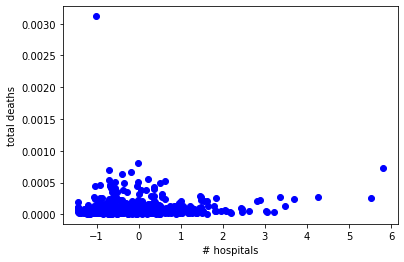

In [65]:
plt.plot(list(combined_data['HospCt']), list(combined_data['normalized_deaths']), 'bo')
plt.xlabel('# hospitals')
plt.ylabel('total deaths')

In [66]:
filter1 = combined_data['Deaths'] > 140
# filter2 = combined_data['deaths'] > 300000
filtered = combined_data.where(filter1)
# filtered.where(filter2, inplace=True)
filtered = filtered.dropna()
filtered.head()

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
31,6037.0,-0.779069,-1.299295,-1.325869,-1.272271,-1.325869,-1.520647,-1.526437,-1.520647,0.407244,-0.882272,2.034368,0.012217,0.518441,-0.640034,-0.562610,1.415432,0.112324,0.134761,-0.479266,-0.254088,0.458226,13.006333,1.533619,-1.379106,-1.367917,2.299196,-0.371340,-0.143773,1.201661,1.937522,-0.503191,269,2.66191e-05
65,9001.0,-0.837333,-1.013158,-1.241067,-0.925047,-1.241067,-1.282980,-0.989525,-1.282980,0.140088,0.211454,-0.220424,1.463377,0.016878,0.577870,-0.082298,0.210423,0.704741,-0.076856,0.247120,0.867616,-0.033182,0.622080,-0.240299,-1.053521,-0.692535,0.382086,-0.078347,-1.534655,1.351577,2.408133,-0.503191,178,0.000188595
66,9003.0,-0.615782,-0.858958,-0.823817,-0.899830,-0.823817,-0.995567,-1.063665,-0.995567,0.069681,-0.882272,-0.139896,0.570355,0.160182,-0.418217,0.180458,-0.489259,-0.128054,-0.303500,-0.447025,0.244575,-0.117576,0.552971,-0.183350,-1.032953,-0.649870,0.265979,0.150736,-1.674618,0.527038,0.682560,-0.503191,369,0.000413354
69,9009.0,-0.486541,-0.679530,-0.854952,-0.944452,-0.854952,-0.994007,-1.050062,-0.994007,0.128728,0.211454,-0.260688,0.300589,0.303486,-0.706998,0.230307,-0.605873,-0.473677,-0.458608,-0.674141,0.194598,0.281568,0.505556,-0.250830,-1.017424,-0.617656,0.278112,0.096020,-1.595889,0.751913,1.153171,-0.503191,229,0.000267018
94,12086.0,0.323499,-0.374142,-0.413482,-0.424412,-0.413482,-0.862419,-0.875838,-0.862419,0.097535,-0.882272,1.470670,-0.266852,-0.054774,-0.489366,-0.009766,1.570917,0.875990,-0.287304,-0.735582,-0.543987,0.233794,3.079221,0.417407,-1.289909,-1.182890,3.674577,0.329190,1.614512,0.676954,0.839430,-0.503191,207,7.49571e-05


In [67]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2].reshape(1, -1).T
Y = data_arr[:,3].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.7062587832514645

In [68]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2:10].reshape(8, -1).T
Y = data_arr[:,10].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.01881968742218454

In [69]:
len(combined_data.columns)

34

In [70]:
print(combined_data.columns[0:20])

Index(['FIPS', '1 Month Prior Intra-Mobility', '1 Month Prior Inter-Mobility',
       '2wk Prior Intra-Mobility', '2wk Onset Intra-Mobility',
       '2wk Post Intra-Mobility', '2wk Prior Inter-Mobility',
       '2wk Onset Inter-Mobility', '2wk Post Inter-Mobility',
       'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018',
       'Total_age65plus', 'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'],
      dtype='object')


In [71]:
combined_data.head()

,FIPS,1 Month Prior Intra-Mobility,1 Month Prior Inter-Mobility,2wk Prior Intra-Mobility,2wk Onset Intra-Mobility,2wk Post Intra-Mobility,2wk Prior Inter-Mobility,2wk Onset Inter-Mobility,2wk Post Inter-Mobility,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,Area in square miles - Land area,NursingCt,HospCt,Hispanic Population,Black Population,Outbreak Month Temp AVG / F,Time from outbreak to intervention,Time from outbreak to national intervention,Time from national intervention to outbreak,Deaths,normalized_deaths
0,1003.0,2.126160,1.613201,2.930109,2.642543,2.930109,2.617561,2.164933,2.617561,-0.239328,1.305179,-0.300952,-0.034295,-0.269730,0.414645,0.883149,-0.217161,-0.312119,-1.607964,0.370213,-0.195225,-1.212098,-0.359016,0.258286,0.142020,-0.366812,-0.663966,-0.373652,1.010922,-0.822207,-0.886143,0.714802,6,2.75202e-05
3,1051.0,1.976836,2.705707,2.954639,2.842882,2.954639,4.475424,4.324851,4.475424,-0.235513,0.211454,0.484199,-0.666851,-0.413033,0.644834,-0.239274,-0.217161,-0.621800,-1.601702,-0.702601,1.155952,-0.618272,-0.543035,-0.243611,1.806777,-0.252580,-0.774031,0.602986,1.798213,-1.721703,-0.886143,2.264974,7,8.54837e-05
6,1073.0,2.441406,2.279821,1.841919,1.754155,1.841919,1.477280,1.532079,1.477280,-0.105273,-0.882272,-0.180160,0.068031,-0.198078,0.197013,-0.087983,-0.450388,0.512166,0.354864,-0.026454,-0.534353,-0.159291,0.237478,0.011032,-0.898539,-0.371046,-0.708818,2.319588,0.757239,0.452080,0.368819,-0.503191,31,4.70196e-05
7,1081.0,2.320088,3.039632,1.695938,1.770605,1.695938,1.828681,2.111964,1.828681,-0.206733,1.305179,-0.341216,0.226170,-0.269730,-0.313586,-0.929576,0.132681,1.036701,-1.497602,-0.060485,-0.343419,3.282705,-0.432119,-0.249264,0.654875,-0.090813,-0.723703,0.730364,0.800977,0.302164,0.055079,-0.503191,22,0.000134195
8,1089.0,1.782042,1.167524,1.517825,1.653192,1.517825,0.987019,1.076434,0.987019,-0.154306,0.211454,-0.462009,0.933145,-0.341382,0.929430,-0.261015,-1.111199,-0.783442,1.654631,-0.589361,-0.041842,0.463142,-0.158286,-0.148993,-0.487861,0.480848,-0.635543,0.871903,0.608528,-0.147584,-0.886143,-0.503191,4,1.09135e-05
